# Survey data 

Initial analysis after data phase 2 collection completed.

Using survey data only (no Amazon data)

- Probe demographics 
- Analysis around other survey questions
- Analysis for behavior experiments

Also check:

- Data check: is the number of completions consistent across experiment arms?
- what is the overall share rate?
- how does the share rate differ by experiment arm?

In [6]:
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import chisquare
import statsmodels.api as sm
import statsmodels.formula.api as smf

data_filepath = '../data/survey-data/survey.csv'
fields_filepath = '../data/survey-data/fields.csv'

In [7]:
# Reminder: Here are the fields
fields_df = pd.read_csv(fields_filepath)
fields_df

,Unnamed: 0,fields
0,Duration (in seconds),Duration (in seconds)
1,RecordedDate,Recorded Date
2,ResponseId,Response ID
3,Q-prolific,What is your Prolific ID?
4,Q-prolific-mturk,Do you also complete surveys (or HITs) using A...
5,q-demos-age,What is your age group?
6,Q-demos-hispanic,"Are you of Spanish, Hispanic, or Latino origin?"
7,Q-demos-race,Choose one or more races that you consider you...
8,Q-demos-education,What is the highest level of education you hav...
9,Q-demos-income,What was your total household income before ta...


In [29]:
df = pd.read_csv(data_filepath)
print('shape:', df.shape)
print('all fields:', df.columns)
df.head(2)

shape: (6325, 41)
all fields: Index(['Duration (in seconds)', 'RecordedDate', 'ResponseId',
       'Q-prolific-mturk', 'q-demos-age', 'Q-demos-hispanic', 'Q-demos-race',
       'Q-demos-education', 'Q-demos-income', 'Q-demos-gender',
       'Q-sexual-orientation', 'Q-demos-state', 'Q-amazon-use-howmany',
       'Q-amazon-use-hh-size', 'Q-amazon-use-how-oft', 'Q-substance-use_1',
       'Q-substance-use_2', 'Q-substance-use_3', 'Q-personal_1',
       'Q-personal_2', 'Q-life-changes', 'Q-control', 'Q-altruism',
       'Q-bonus-05', 'Q-bonus-20', 'Q-bonus-50', 'Q-data-value-05',
       'Q-data-value-20', 'Q-data-value-50', 'Q-data-value-100',
       'Q-data-value-any', 'Q-data-value-any_1_TEXT', 'Q-sell-YOUR-data',
       'Q-sell-consumer-data', 'Q-small-biz-use', 'Q-census-use',
       'Q-research-society', 'Q-attn-check', 'showdata', 'incentive',
       'connect'],
      dtype='object')


,Duration (in seconds),RecordedDate,ResponseId,Q-prolific-mturk,q-demos-age,Q-demos-hispanic,Q-demos-race,Q-demos-education,Q-demos-income,Q-demos-gender,...,Q-data-value-any_1_TEXT,Q-sell-YOUR-data,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,Q-research-society,Q-attn-check,showdata,incentive,connect
0,332,9/21/2022 10:00:17,R_1ou69fj4DQGsVcp,NaN,35 - 44 years,No,Black or African American,High school diploma or GED,"$25,000 - $49,999",Female,...,NaN,No,No,No,No,No,"Yes,No,I don't know",False,bonus-50,NaN
1,488,9/21/2022 10:02:24,R_24dboHVOzohx1kw,NaN,25 - 34 years,No,White or Caucasian,Bachelor's degree,"$25,000 - $49,999",Male,...,NaN,Yes if I get part of the profit,Yes,No,Yes,Yes,"Yes,No,I don't know",False,bonus-05,NaN


## Sharing behavior

In [30]:
df[
    ['Q-control', 'Q-altruism', 'Q-bonus-05', 'Q-bonus-20', 'Q-bonus-50', 'showdata', 'incentive']
].head()

,Q-control,Q-altruism,Q-bonus-05,Q-bonus-20,Q-bonus-50,showdata,incentive
0,NaN,NaN,NaN,NaN,Consent to share (receive $0.50 bonus),False,bonus-50
1,NaN,NaN,Decline,NaN,NaN,False,bonus-05
2,NaN,NaN,Consent to share (receive $0.05 bonus),NaN,NaN,False,bonus-05
3,NaN,NaN,NaN,NaN,Consent to share (receive $0.50 bonus),False,bonus-50
4,Consent to share,NaN,NaN,NaN,NaN,True,control


In [31]:
# add boolean indicating share
df['share'] = df[
    ['Q-control', 'Q-altruism', 'Q-bonus-05', 'Q-bonus-20', 'Q-bonus-50', 'incentive']
].apply(lambda r: 1 if 'consent' in str(r['Q-'+r['incentive']]).lower() else 0, axis=1)
df[['Q-control', 'Q-altruism', 'Q-bonus-05', 'Q-bonus-20', 'Q-bonus-50', 'showdata', 'incentive', 'share']].head()

,Q-control,Q-altruism,Q-bonus-05,Q-bonus-20,Q-bonus-50,showdata,incentive,share
0,NaN,NaN,NaN,NaN,Consent to share (receive $0.50 bonus),False,bonus-50,1
1,NaN,NaN,Decline,NaN,NaN,False,bonus-05,0
2,NaN,NaN,Consent to share (receive $0.05 bonus),NaN,NaN,False,bonus-05,1
3,NaN,NaN,NaN,NaN,Consent to share (receive $0.50 bonus),False,bonus-50,1
4,Consent to share,NaN,NaN,NaN,NaN,True,control,1


Aggregate the data

Make a table:
```
incentive, showdata, count, share rate
```

In [32]:
def get_aggregate_share_df(df):
    return df.groupby(['incentive','showdata'])['share'].agg(['count','mean']).round(3).reset_index()

agg_share_df = get_aggregate_share_df(df)
agg_share_df

,incentive,showdata,count,mean
0,altruism,False,653,0.767
1,altruism,True,642,0.816
2,bonus-05,False,647,0.720
3,bonus-05,True,618,0.785
4,bonus-20,False,648,0.765
5,bonus-20,True,602,0.834
6,bonus-50,False,624,0.830
7,bonus-50,True,616,0.888
8,control,False,636,0.763
9,control,True,639,0.779


In [33]:
# overall
N = agg_share_df['count'].sum()
overall_share_rate = df['share'].mean().round(3)

print('N = %s' % N)
print('overall share rate: %s' % overall_share_rate)

N = 6325
overall share rate: 0.794


In [34]:
# What about for just the control condition?
def get_control_df(df=df):
    return df[df['incentive']=='control']
control_df = get_control_df(df)
control_N = len(control_df)
control_share_rate = control_df['share'].mean().round(3)
print('control N = %s' % control_N)
print('control share rate: %s' % control_share_rate)

control N = 1275
control share rate: 0.771


In [43]:
def plot_count(pdf, ax):
    width = 0.4
    (pdf[pdf['showdata']==True]['count']
     .plot(
        kind='bar', color='lightgray', edgecolor='black', #hatch='//',
        label='show data = true',
        ax=ax, width=width, position=1
    ))
    (pdf[pdf['showdata']==False]['count']
     .plot(
        kind='bar', color='black', 
        edgecolor='black', 
        label='show data = false',
        ax=ax, width=width, position=0)
    )
    ax.set_ylabel('Completions')
    ax.set_xlabel('incentive (random experiment arm)')
    ax.set_xlim([-0.5,4.5])
    ax.legend(facecolor='white', framealpha=0.98, loc='lower right')
    _ = ax.set_xticklabels(pdf[pdf['showdata']==True]['incentive'], rotation=0)

#### Data check: is the number of completions consistent across experiment arms?

Use chi-square test of homogeneity.

Null hypothesis: Completions count is the same across experimental arms

chi-square test null hypothesis: Completions count is the same across experimental arms
chi-square test result: stat=3.953, p-value=0.914
We do not reject the null hypothesis


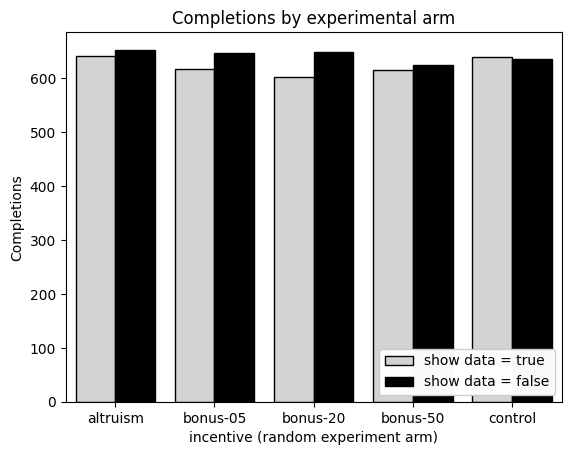

In [44]:
# plot count
fig,ax = plt.subplots(1,1)#, dpi=150)
ax.set_title('Completions by experimental arm')
plot_count(agg_share_df, ax)
# chi-square test
(statistic, pvalue) = chisquare(agg_share_df['count'])
print('chi-square test null hypothesis: Completions count is the same across experimental arms')
print('chi-square test result: stat=%0.3f, p-value=%0.3f' % (statistic, pvalue))
if pvalue > 0.05:
    print('We do not reject the null hypothesis')
else:
    print('We reject the null hypothesis')

In [41]:
def plot_share_rate(pdf, ax, overall_share_rate=overall_share_rate):
    width = 0.4
    (pdf[pdf['showdata']==True]['mean']
     .plot(
        kind='bar', color='lightgray', edgecolor='black', #hatch='//',
        label='show data = true',
        ax=ax, width=width, position=1
    ))
    (pdf[pdf['showdata']==False]['mean']
     .plot(
        kind='bar', color='black', 
        edgecolor='black', 
        label='show data = false',
        ax=ax, width=width, position=0)
    )
    if overall_share_rate is not None:
        ax.hlines(overall_share_rate, -1, 5, color='gray', label='overall')
    ax.set_ylabel('Share rate')
    ax.set_xlabel('incentive (random experiment arm)')
    ax.set_xlim([-0.5,4.5])
    ax.legend(facecolor='white', framealpha=0.98, loc='lower right')
    ax.set_ylim([0,1])
    _ = ax.set_xticklabels(pdf[pdf['showdata']==True]['incentive'], rotation=0)

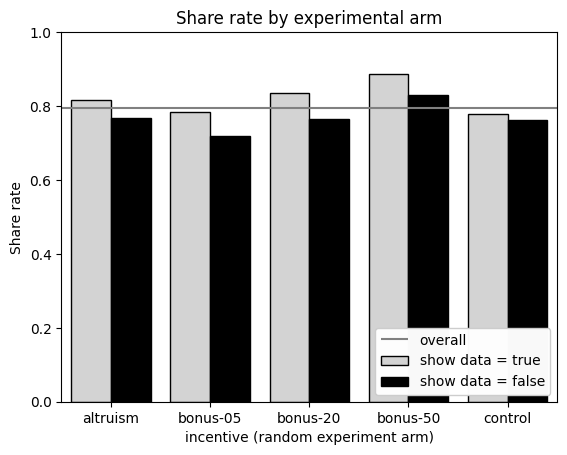

In [42]:
fig,ax = plt.subplots(1,1)#, dpi=150)
ax.set_title('Share rate by experimental arm')
plot_share_rate(agg_share_df, ax)

observations:

- more money reward --> more sharing
- showdata=true consistently higher share rate (like before, more consistent)
- incentive bonus: \$0.05 x (show data=False) has negative effect compared to control
- incentive: altruism x (show data=True) increases sharing vs control